In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from PIL import Image
from IPython.display import display


In [14]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [15]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [16]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [17]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
meso.load('./weights/Meso4_DF')

In [18]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 7104 images belonging to 2 classes.


In [19]:
# Checking class assignment
generator.class_indices

{'DeepFake': 0, 'Real': 1}

In [20]:
# '.ipynb_checkpoints' is a *hidden* file Jupyter creates for autosaves
# It must be removed for flow_from_directory to work.
!rmdir /s /q c:data\.ipynb_checkpoints

# Equivalent command in Unix (for Mac / Linux users)
# !rm -r /Users/mikhaillenko/mesonet/mesonet/data/.ipynb_checkpoints/

The system cannot find the file specified.


In [21]:
# Recreating generator after removing '.ipynb_checkpoints'
dataGenerator = ImageDataGenerator(rescale=1./255)

generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

# Re-checking class assignment after removing it
generator.class_indices

Found 7104 images belonging to 2 classes.


{'DeepFake': 0, 'Real': 1}

1/1 [==============================] - 0s 235ms/step
Predicted likelihood: 0.0812
Actual label: 0

Correct prediction: True


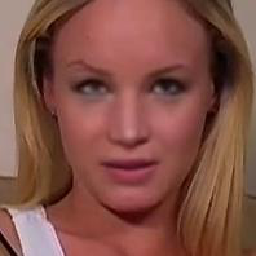

In [22]:
# Generate image X and label y
X, y = generator.next()

# Evaluate prediction once and store the result
prediction = meso.predict(X)[0][0]

# Print predicted likelihood and actual label
print(f"Predicted likelihood: {prediction:.4f}")
print(f"Actual label: {int(y[0])}")

# Check if the prediction is correct
correct = round(prediction) == y[0]
print(f"\nCorrect prediction: {correct}")

# Show the image (ensure plt is properly imported and configured)
# Convert numpy array to PIL Image
img = Image.fromarray(np.squeeze((X * 255).astype(np.uint8)))

# Display the image inline
display(img)

In [25]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [37]:
import sys
import os
from contextlib import redirect_stdout

def silent_predict(model, x):
    with open(os.devnull, 'w') as fnull:
        with redirect_stdout(fnull):
            return model.predict(x)

# Usage
pred = silent_predict(meso.model, X)

In [41]:
from tqdm import tqdm

# Generating predictions on validation set, storing in separate lists
for i in tqdm(range(len(generator.labels)), desc="Processing images"):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = silent_predict(meso, X)[0][0]
    
    # Sorting into proper category
    if round(pred) == y[0] and y[0] == 1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred) == y[0] and y[0] == 0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0] == 1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)
    
# Final status message
print(f"All {len(generator.labels)} predictions completed.")

Processing images: 100%|██████████| 7104/7104 [13:11<00:00,  8.97it/s]

All 7104 predictions completed.


In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Combine the labels for correct and misclassified categories
y_true = [1] * len(correct_real) + [0] * len(correct_deepfake) + [1] * len(misclassified_real) + [0] * len(misclassified_deepfake)
y_pred = [1] * len(correct_real) + [0] * len(correct_deepfake) + [0] * len(misclassified_real) + [1] * len(misclassified_deepfake)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report with explicit labels
class_report = classification_report(y_true, y_pred, labels=[0, 1], target_names=['Deepfake', 'Real'])
print("Classification Report:")
print(class_report)


Accuracy: 0.8907
Confusion Matrix:
[[3705  388]
 [ 730 5404]]
Classification Report:
              precision    recall  f1-score   support

    Deepfake       0.84      0.91      0.87      4093
        Real       0.93      0.88      0.91      6134

    accuracy                           0.89     10227
   macro avg       0.88      0.89      0.89     10227
weighted avg       0.89      0.89      0.89     10227



In [43]:
# After training your model
meso.model.save('Meso4_model.h5')

print("Model saved as 'Meso4_model.h5'")

Model saved as 'Meso4_model.h5'
